#### Importing Libraries

In [1]:
import numpy as np
from PIL import Image
import random
import glob
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LearningCurveDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from scipy.stats import multivariate_normal as mvn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(1)
random.seed(2)

In [3]:
def load_image(file):
    subject = []
    for filename in glob.glob(file):
        im=Image.open(filename)
        subject.append(im.convert("L"))
    return subject

In [4]:
def resize(image):
    mat = []
    for i in image:
        mat.append(np.asarray((i.resize(size = (64, 64)))))
    #print(mat)
    mat = np.array(mat)
    #print(mat.shape)
    mat_flat = mat.reshape(len(image),4096)
    return mat_flat

In [5]:
def create_y(train, n):
    y = np.zeros((train.shape[0],1))
    y.fill(n)
    return y

In [6]:
def load_data(binary = False):
    """
    This function reads the images, resize them, and then shuffle
    return: full (array)
    """
    train_1 = load_image('Training/glioma/*.jpg')
    train_2 = load_image('Training/meningioma/*.jpg')
    train_3 = load_image('Training/notumor/*.jpg')
    train_4 = load_image('Training/pituitary/*.jpg')
    test_1 = load_image('Testing/glioma/*.jpg')
    test_2 = load_image('Testing/meningioma/*.jpg')
    test_3 = load_image('Testing/notumor/*.jpg')
    test_4 = load_image('Testing/pituitary/*.jpg')
    te_sm_1 = resize(test_1)
    te_sm_2 = resize(test_2)
    te_sm_3 = resize(test_3)
    te_sm_4 = resize(test_4)
    if binary == False:
        y_te_1 = create_y(te_sm_1, 0)
        y_te_2 = create_y(te_sm_2, 1)
        y_te_3 = create_y(te_sm_3, 2)
        y_te_4 = create_y(te_sm_4, 3)
    else:
        y_te_1 = create_y(te_sm_1, 1)
        y_te_2 = create_y(te_sm_2, 1)
        y_te_3 = create_y(te_sm_3, 0)
        y_te_4 = create_y(te_sm_4, 1)
    tr_sm_1 = resize(train_1)
    tr_sm_2 = resize(train_2)
    tr_sm_3 = resize(train_3)
    tr_sm_4 = resize(train_4)

    if binary == False:
        y_1 = create_y(tr_sm_1, 0)
        y_2 = create_y(tr_sm_2, 1)
        y_3 = create_y(tr_sm_3, 2)
        y_4 = create_y(tr_sm_4, 3)
    else:
        y_1 = create_y(tr_sm_1, 1)
        y_2 = create_y(tr_sm_2, 1)
        y_3 = create_y(tr_sm_3, 0)
        y_4 = create_y(tr_sm_4, 1)        

    full_x = np.vstack((tr_sm_1, tr_sm_2, tr_sm_3, tr_sm_4, te_sm_1, te_sm_2, te_sm_3, te_sm_4))
    full_y = np.vstack((y_1, y_2, y_3, y_4, y_te_1, y_te_2, y_te_3, y_te_4))
    full = np.hstack((full_x, full_y))
    np.random.shuffle(full)
    full_x = full[:, :-1]
    full_y = full[:, -1]

    if binary == True:
        oversample = SMOTE()
        full_x, full_y = oversample.fit_resample(full_x,full_y)

    return full_x, full_y

In [7]:
def pca_analysis(x, plot = False, binary = False):
    """

    x: array
    Plotting elbow graph, default set as False
    """
    
    if plot == True:
        pca = PCA(n_components = 20)
        pca_fit = pca.fit(x)
        PC_values = np.arange(pca_fit.n_components_) + 1
        fig, ax = plt.subplots()
        ax.plot(PC_values, pca.explained_variance_ratio_, linewidth=2)
        ax.set_title('Variance Explained at various number of Principal Components')
        ax.set_xticks(list(range(21)))
        ax.set_xlabel('Principal Component')
        ax.set_ylabel('Variance Explained')
        plt.show()
    if binary == True:
        pca = PCA(n_components=2)
    else:
        pca = PCA(n_components=3)
    pca_fit = pca.fit(x)
    pca_x = pca.transform(x)
    return pca_x


In [8]:
def splitting(x, y, tt_split):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = tt_split, random_state = 4980572)
    return x_train, x_test, y_train, y_test

In [9]:
def learning_curves(x, y, model):
    fig, ax = plt.subplots(figsize=(10, 6), sharey=True)

    common_params = {
        "X": x,
        "y": y,
        "train_sizes": np.linspace(0.1, 1.0, 5),
        "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
        "score_type": "both",
        "n_jobs": 4,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "score_name": "Accuracy",
    }

    for ax_idx, estimator in enumerate([model]):
        LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
        handles, label = ax.get_legend_handles_labels()
        ax.legend(handles[:2], ["Training Score", "Test Score"])

In [10]:
def standard_fit(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train.ravel())
    y_model = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_model)
    print("Accuracy:", round(accuracy*100,2))
    print(classification_report(y_model,y_test))
    cm = confusion_matrix(y_test, y_model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [11]:
def grid_search(param_grid, x_train, y_train, x_test, y_test, model):
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3,n_jobs=-1, return_train_score=True)
    grid.fit(x_train, y_train) 
    print("Best parameters:", grid.best_params_) 
    grid_predictions = grid.predict(x_test) 
    print(classification_report(y_test, grid_predictions)) 
    cm = confusion_matrix(y_test, grid_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

## Multi-Class Classification

In [12]:
### Main Constructor
full_x, full_y = load_data()
# pca_analysis()

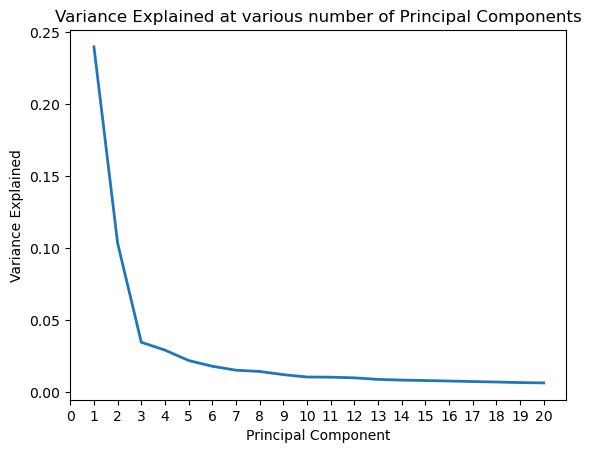

In [13]:
full_x = pca_analysis(full_x, plot=True)

In [14]:
x_train, x_test, y_train, y_test = splitting(full_x, full_y, 0.2)

### Learning Curves

Text(0.5, 1.0, 'Learning Curve for Logistic Regression')

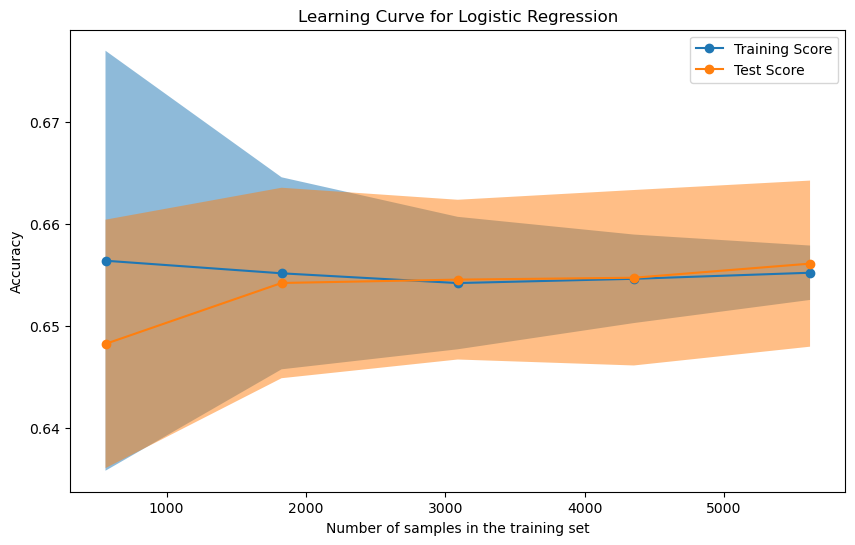

In [21]:
logr = LogisticRegression()
learning_curves(full_x, full_y, logr)
plt.title("Learning Curve for Logistic Regression")

The training and test scores remain mostly the same, with test scores going above train scores as the number of samples in the training set increases. One explanation for why the test score might be higher than train score is due to high bias, which is common with linear models such as logistic regression, especially when the input data is nonlinear (image data in this case).


Text(0.5, 1.0, 'Learning Curve for RBF SVM')

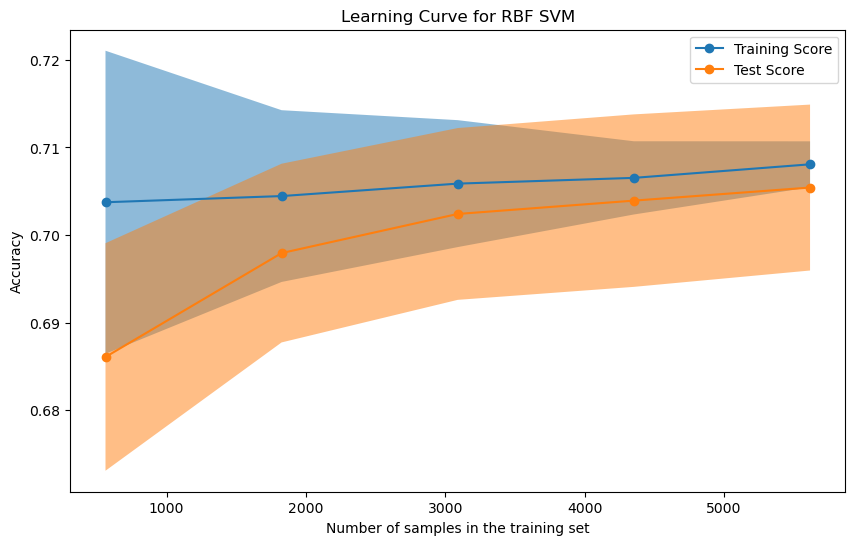

In [15]:
svm = SVC(kernel='rbf')
learning_curves(full_x, full_y, svm)
plt.title("Learning Curve for RBF SVM")

The training score stays mostly stable with a gradual increase, whereas the test score increases sharply initially after more samples are added, then gradually tapering off. The curve doesn't show underfitting or overfitting behavior.

Text(0.5, 1.0, 'Learning Curve for Naive-Bayes')

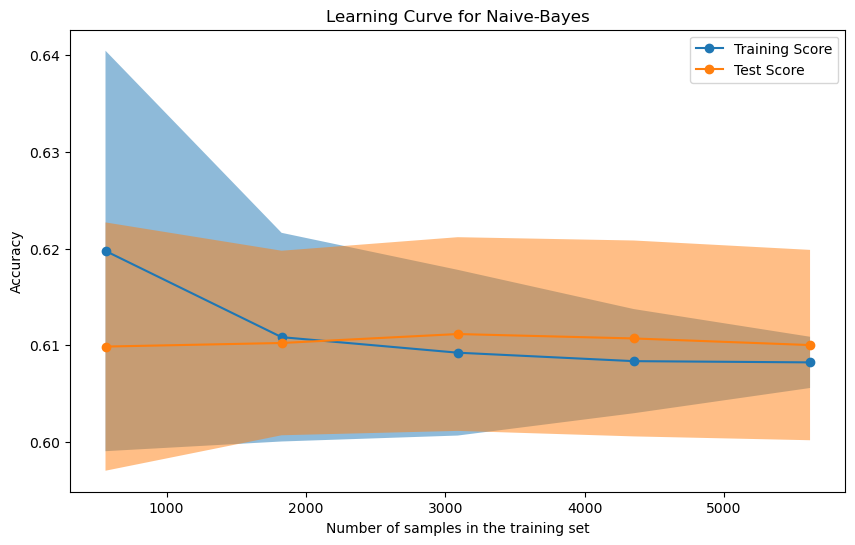

In [16]:
gnb = GaussianNB()
learning_curves(full_x, full_y, gnb)
plt.title("Learning Curve for Naive-Bayes")

For the Naive-Bayes classifier, the learning curve has gradually decreasing accuracy for an increasing number of training samples. One of the reasons for this might be due to the nature of the Naive-Bayes classifier itself, since the model treats all the features as independent variables, and doesn’t need a larger dataset to improve accuracy. The small difference in accuracy between the training and testing also shows that the model is not overfitting, and the test score is
higher than the train score for a bigger number of samples, which is again in-line with how the Naive-Bayes classifier predicts labels. Since it treats the input features as independent, and the test set is much smaller than the train set as the number of training samples increases, it is less likely to predict poorly on the smaller set. 

Text(0.5, 1.0, 'Learning Curve for K Nearest Neighbors')

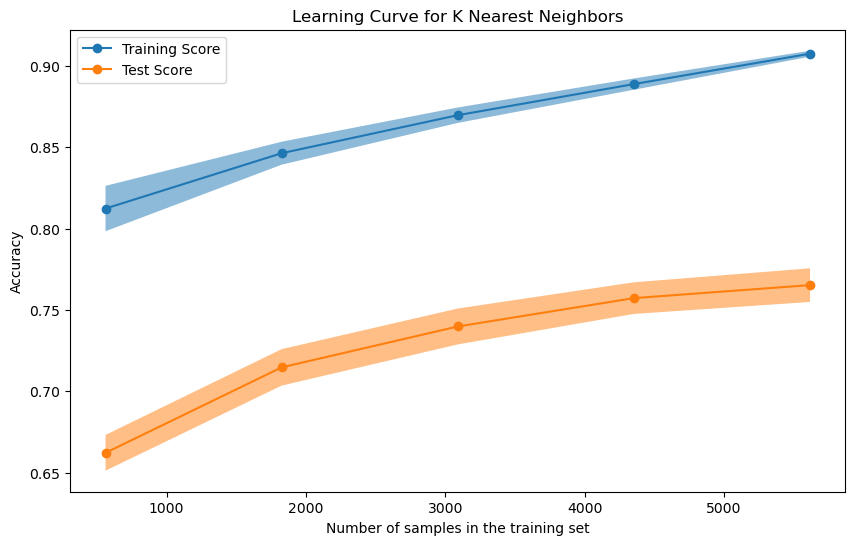

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)
learning_curves(full_x, full_y, knn)
plt.title("Learning Curve for K Nearest Neighbors")

The trend above somewhat follows overfitting behavior; the training and testing score both increase gradually with an increasing number of samples, but the difference between the train and test scores is significant.

Text(0.5, 1.0, 'Learning Curve for MLPClassifier')

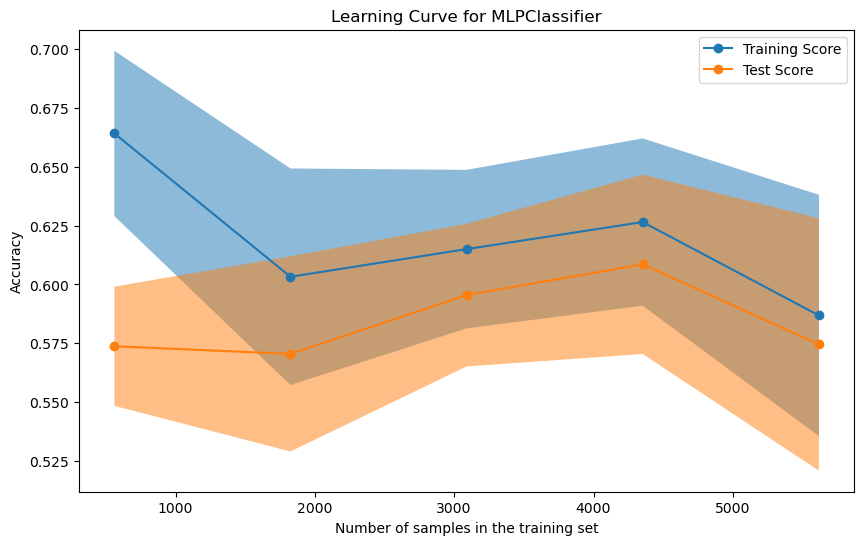

In [18]:
mlpc = MLPClassifier()
learning_curves(full_x, full_y, mlpc)
plt.title("Learning Curve for MLPClassifier")

The above learning curve shows interesting behavior. The training accuracy is very high for a small number of samples in the
training set, then it has a sharp decrease, followed by a gradual increase and another gradual decrease as the maximum number of samples in the training set is reached. The testing accuracy starts low and then follows a similar trend as the training accuracy. This might be an indicator that the model is underfitting (after the initial overfitting for a minimum number of
training samples), as the number of training samples seems to have a net negative impact on the model accuracy for both training and testing sets.

Text(0.5, 1.0, 'Learning Curve for Random Forest Classifier')

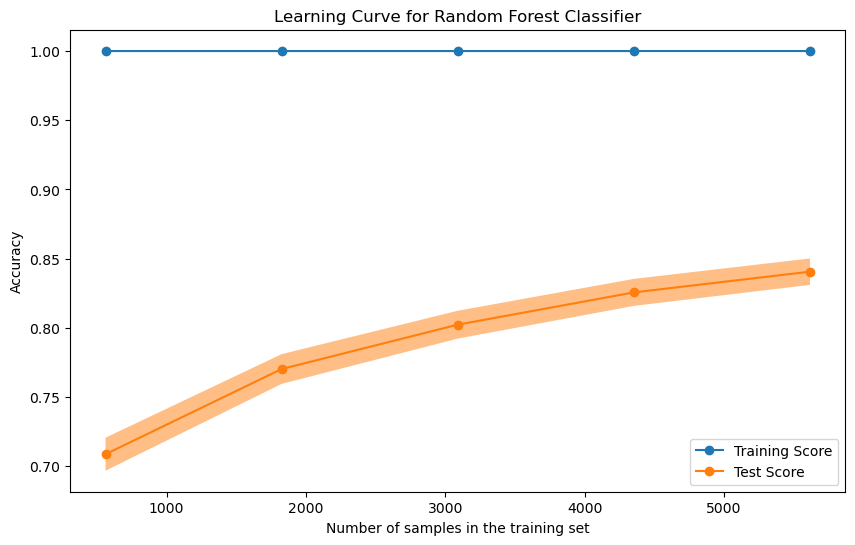

In [19]:
rf = RandomForestClassifier()
learning_curves(full_x, full_y, rf)
plt.title("Learning Curve for Random Forest Classifier")

For the Random Forests classifier, training accuracy is 100% across all training sizes. While this is an indication of overfitting, it is also an indicator of the robustness of the Random Forests classifier, as the accuracy on the testing set
is significantly lower, yet still high relative to other models. The testing accuracy increases as more samples are added to the training sets, indicating that the model is learning from the newer samples and generalization errors are decreasing. It also shows that adding more samples will lead to better accuracy, so the Random Forests classifier will benefit from more information.


### Grid Search & Evaluation Metrics

#### Logistic Regression

Accuracy: 63.84
              precision    recall  f1-score   support

         0.0       0.72      0.61      0.66       365
         1.0       0.35      0.62      0.45       207
         2.0       0.67      0.69      0.68       376
         3.0       0.84      0.63      0.72       457

    accuracy                           0.64      1405
   macro avg       0.65      0.64      0.63      1405
weighted avg       0.69      0.64      0.65      1405



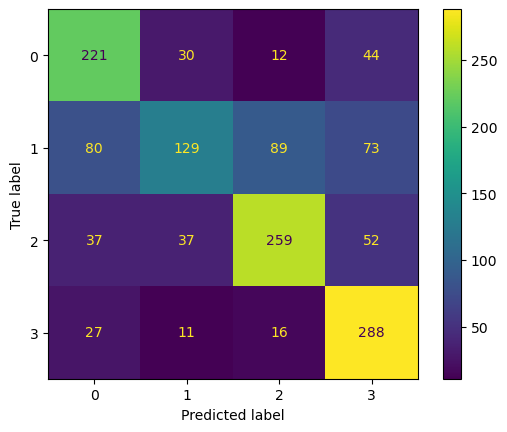

In [22]:
standard_fit(x_train, y_train, x_test, y_test, logr)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
Best parameters: {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.61      0.72      0.66       307
         1.0       0.62      0.35      0.45       371
         2.0       0.69      0.67      0.68       385
         3.0       0.63      0.84      0.72       342

    accuracy                           0.64      1405
   macro avg       0.64      0.65      0.63      1405
weighted avg       0.64      0.64      0.62      1405



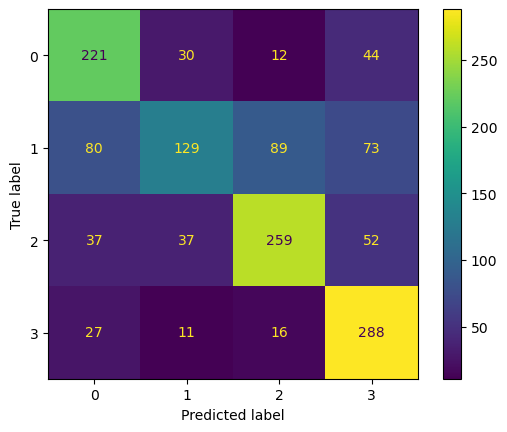

In [23]:
param_grid = {'penalty': ["l2", "elasticnet"], "C": np.linspace(0.001, 1, 100), "l1_ratio": np.linspace(0, 1, 20)}
grid_search(param_grid, x_train, y_train, x_test, y_test, logr)

#### SVM - RBF Kernel

Accuracy: 70.89
              precision    recall  f1-score   support

         0.0       0.71      0.66      0.69       330
         1.0       0.56      0.61      0.58       340
         2.0       0.67      0.81      0.74       318
         3.0       0.91      0.75      0.82       417

    accuracy                           0.71      1405
   macro avg       0.71      0.71      0.71      1405
weighted avg       0.72      0.71      0.71      1405



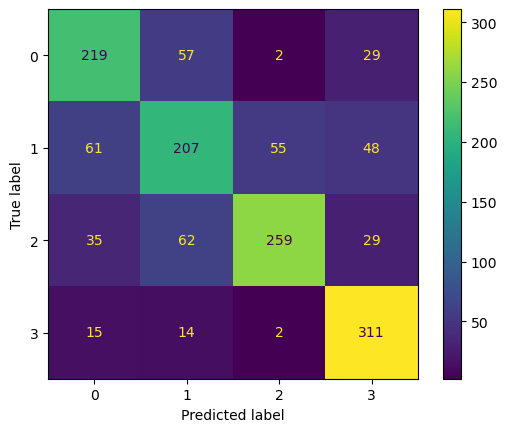

In [24]:
standard_fit(x_train, y_train, x_test, y_test, svm)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001}
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.69       307
         1.0       0.61      0.56      0.58       371
         2.0       0.81      0.67      0.74       385
         3.0       0.75      0.91      0.82       342

    accuracy                           0.71      1405
   macro avg       0.71      0.71      0.71      1405
weighted avg       0.71      0.71      0.71      1405



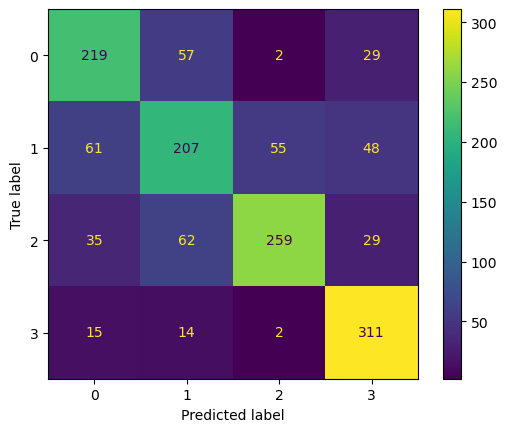

In [25]:
param_grid = {"kernel": ["rbf"], "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'gamma': ['scale', 'auto'], 'tol': [1e-3, 1e-4, 1e-5]}
grid_search(param_grid, x_train, y_train, x_test, y_test, svm)

#### Naive-Bayes

Accuracy: 58.43
              precision    recall  f1-score   support

         0.0       0.77      0.49      0.60       482
         1.0       0.20      0.41      0.27       185
         2.0       0.56      0.80      0.66       272
         3.0       0.85      0.63      0.72       466

    accuracy                           0.58      1405
   macro avg       0.60      0.58      0.56      1405
weighted avg       0.68      0.58      0.61      1405



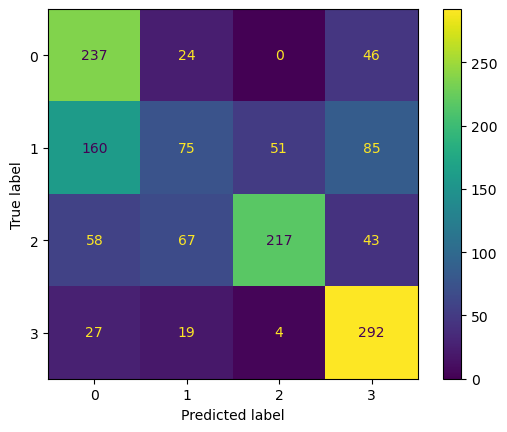

In [26]:
standard_fit(x_train, y_train, x_test, y_test, gnb)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'var_smoothing': 0.001}
              precision    recall  f1-score   support

         0.0       0.49      0.78      0.60       307
         1.0       0.40      0.20      0.26       371
         2.0       0.80      0.56      0.66       385
         3.0       0.63      0.85      0.72       342

    accuracy                           0.58      1405
   macro avg       0.58      0.60      0.56      1405
weighted avg       0.58      0.58      0.56      1405



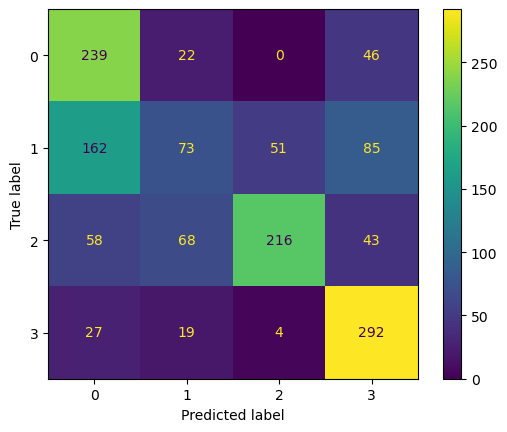

In [27]:
param_grid = {'var_smoothing': np.logspace(-12,-1,12)} 
grid_search(param_grid, x_train, y_train, x_test, y_test, gnb)

#### K-Nearest Neighbors

Accuracy: 76.87
              precision    recall  f1-score   support

         0.0       0.68      0.64      0.66       325
         1.0       0.64      0.72      0.68       331
         2.0       0.89      0.84      0.87       405
         3.0       0.85      0.85      0.85       344

    accuracy                           0.77      1405
   macro avg       0.77      0.76      0.76      1405
weighted avg       0.77      0.77      0.77      1405



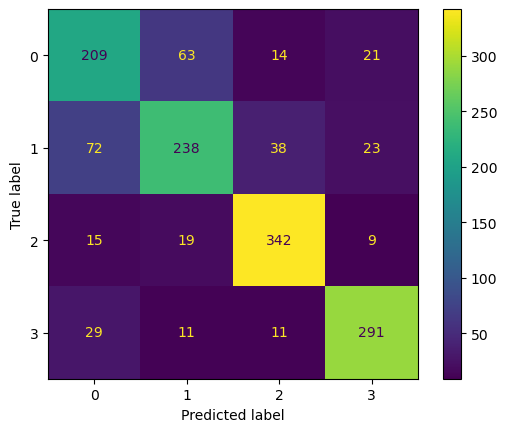

In [28]:
standard_fit(x_train, y_train, x_test, y_test, knn)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.79      0.66      0.72       307
         1.0       0.77      0.80      0.79       371
         2.0       0.90      0.95      0.92       385
         3.0       0.87      0.91      0.89       342

    accuracy                           0.84      1405
   macro avg       0.83      0.83      0.83      1405
weighted avg       0.83      0.84      0.83      1405



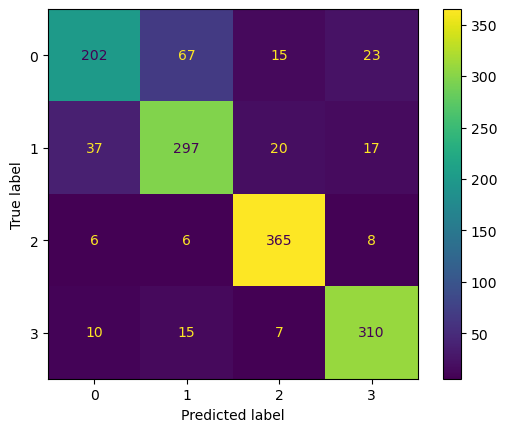

In [29]:
param_grid = {'n_neighbors': [3,4,5,6,7],
             'weights': ['uniform', 'distance'],
             'p': [1,2]} 
grid_knn = grid_search(param_grid, x_train, y_train, x_test, y_test, knn)

#### MLP Classifier

Accuracy: 62.78
              precision    recall  f1-score   support

         0.0       0.72      0.53      0.61       417
         1.0       0.22      0.58      0.31       138
         2.0       0.78      0.69      0.73       433
         3.0       0.83      0.68      0.75       417

    accuracy                           0.63      1405
   macro avg       0.63      0.62      0.60      1405
weighted avg       0.72      0.63      0.66      1405



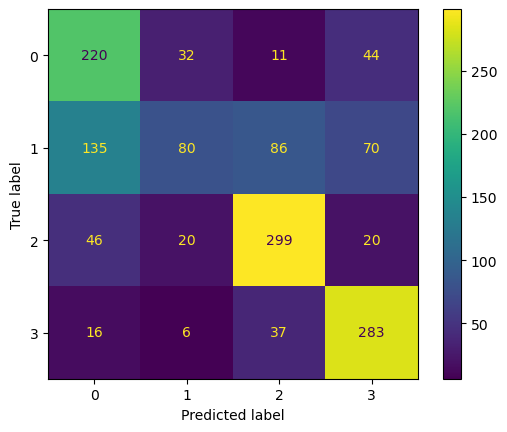

In [30]:
standard_fit(x_train, y_train, x_test, y_test, mlpc)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.61      0.69      0.65       307
         1.0       0.59      0.42      0.49       371
         2.0       0.75      0.76      0.75       385
         3.0       0.69      0.81      0.75       342

    accuracy                           0.67      1405
   macro avg       0.66      0.67      0.66      1405
weighted avg       0.66      0.67      0.66      1405



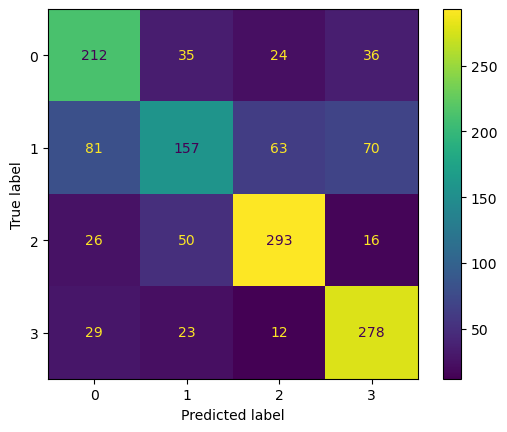

In [31]:
param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100)],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': np.logspace(-5,-1,5)} 
grid_search(param_grid, x_train, y_train, x_test, y_test, mlpc)

#### Random Forests

Accuracy: 83.7
              precision    recall  f1-score   support

         0.0       0.72      0.77      0.75       286
         1.0       0.72      0.79      0.75       340
         2.0       0.94      0.91      0.92       399
         3.0       0.95      0.86      0.90       380

    accuracy                           0.84      1405
   macro avg       0.83      0.83      0.83      1405
weighted avg       0.85      0.84      0.84      1405



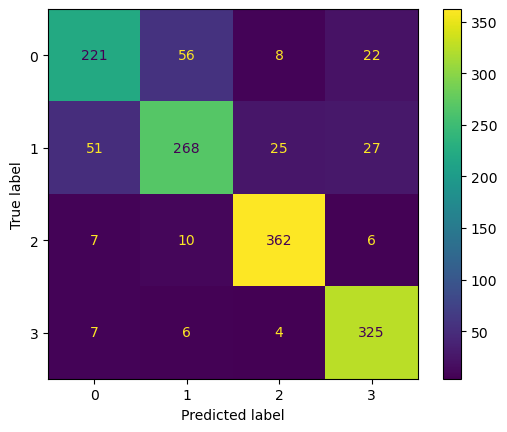

In [32]:
standard_fit(x_train, y_train, x_test, y_test, rf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'bootstrap': False, 'max_features': 'auto', 'n_estimators': 750}
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.75       307
         1.0       0.80      0.76      0.78       371
         2.0       0.92      0.95      0.93       385
         3.0       0.88      0.94      0.91       342

    accuracy                           0.85      1405
   macro avg       0.84      0.84      0.84      1405
weighted avg       0.85      0.85      0.85      1405



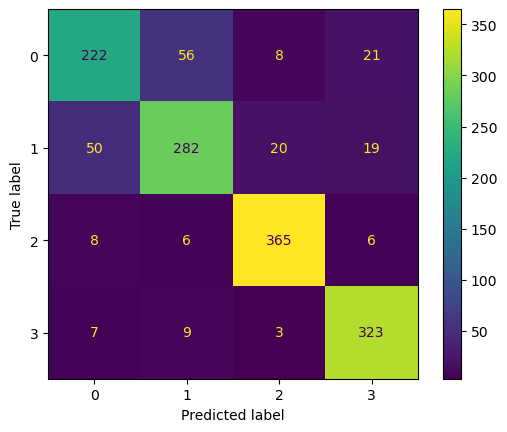

In [33]:
param_grid = {'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt', 'log2'],            
 'n_estimators': [100, 250, 500, 750, 1000]} 
grid_rf = grid_search(param_grid, x_train, y_train, x_test, y_test, rf)


## Binary Classification

In [34]:
bin_x, bin_y = load_data(binary=True)


In [35]:
bin_x = pca_analysis(bin_x, binary=True)

In [36]:
bin_x_train, bin_x_test, bin_y_train, bin_y_test = splitting(bin_x, bin_y, 0.2)

### Learning Curves

Text(0.5, 1.0, 'Learning Curve for Logistic Regression')

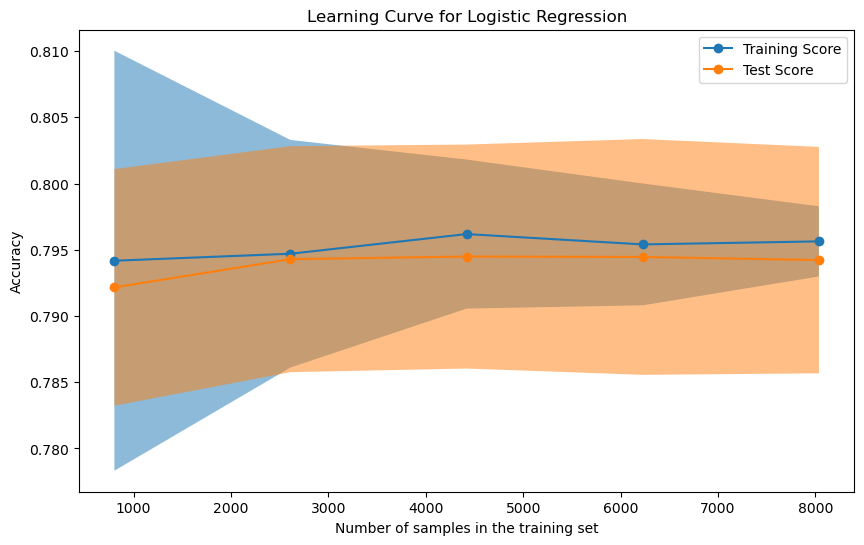

In [37]:
logr = LogisticRegression()
learning_curves(bin_x, bin_y, logr)
plt.title("Learning Curve for Logistic Regression")

Text(0.5, 1.0, 'Learning Curve for RBF SVM')

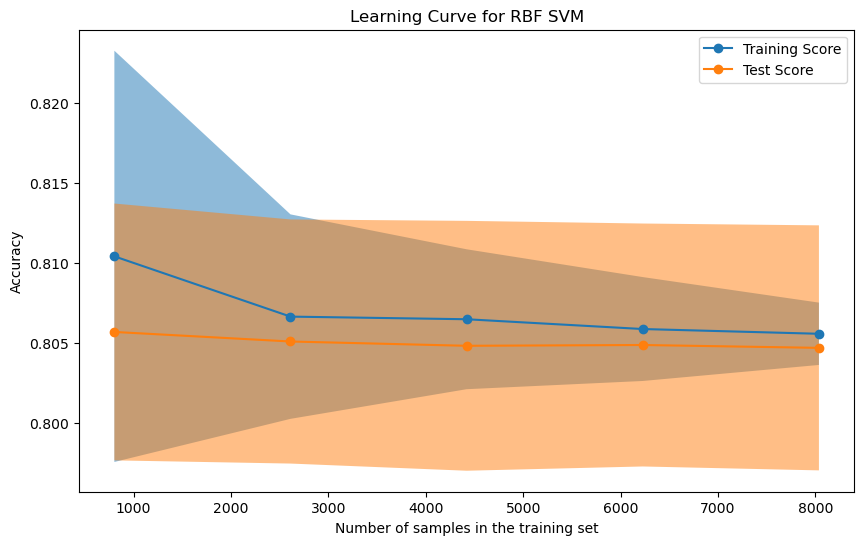

In [38]:
svm = SVC(kernel='rbf')
learning_curves(bin_x, bin_y, svm)
plt.title("Learning Curve for RBF SVM")

Text(0.5, 1.0, 'Learning Curve for Naive-Bayes')

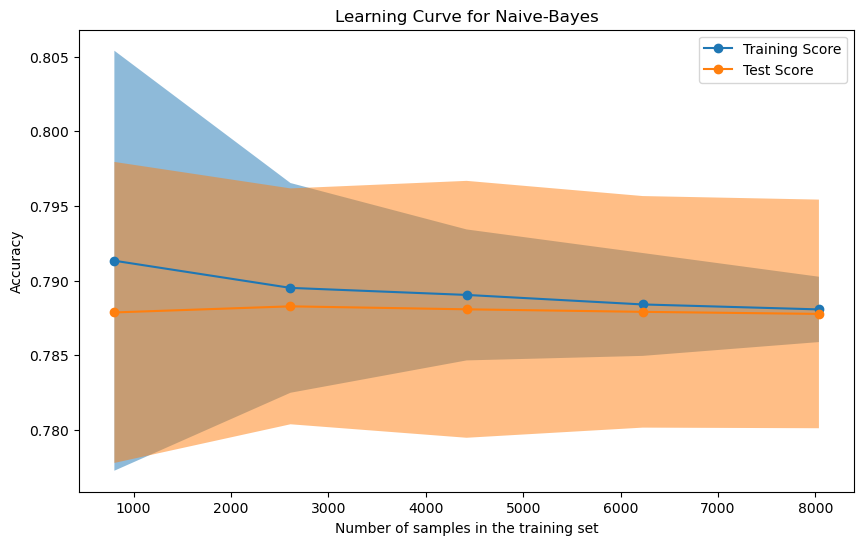

In [39]:
gnb = GaussianNB()
learning_curves(bin_x, bin_y, gnb)
plt.title("Learning Curve for Naive-Bayes")

Text(0.5, 1.0, 'Learning Curve for K Nearest Neighbors')

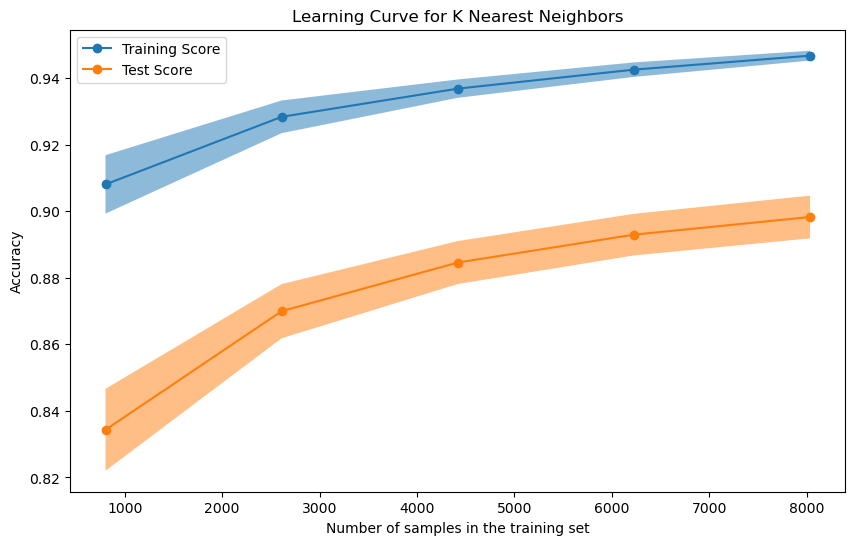

In [40]:
knn = KNeighborsClassifier(n_neighbors=3)
learning_curves(bin_x, bin_y, knn)
plt.title("Learning Curve for K Nearest Neighbors")

Text(0.5, 1.0, 'Learning Curve for MLPClassifier')

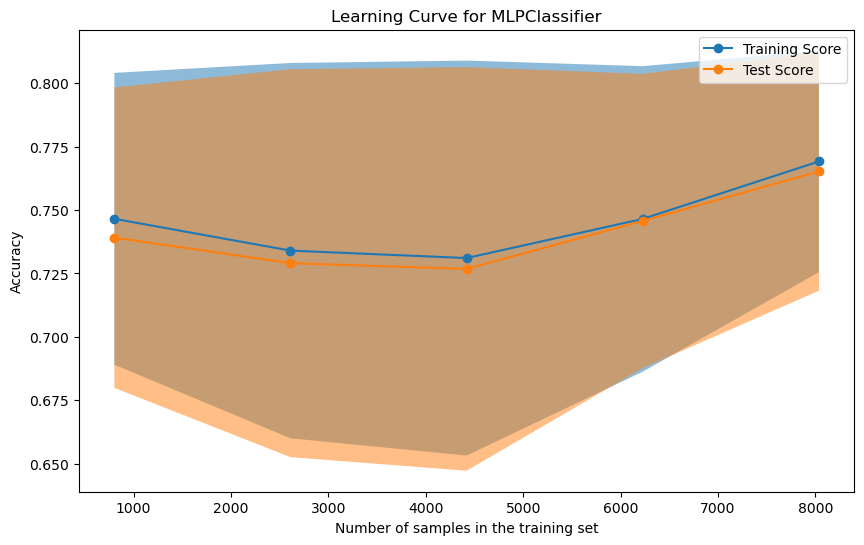

In [41]:
mlpc = MLPClassifier()
learning_curves(bin_x, bin_y, mlpc)
plt.title("Learning Curve for MLPClassifier")

Text(0.5, 1.0, 'Learning Curve for Random Forest Classifier')

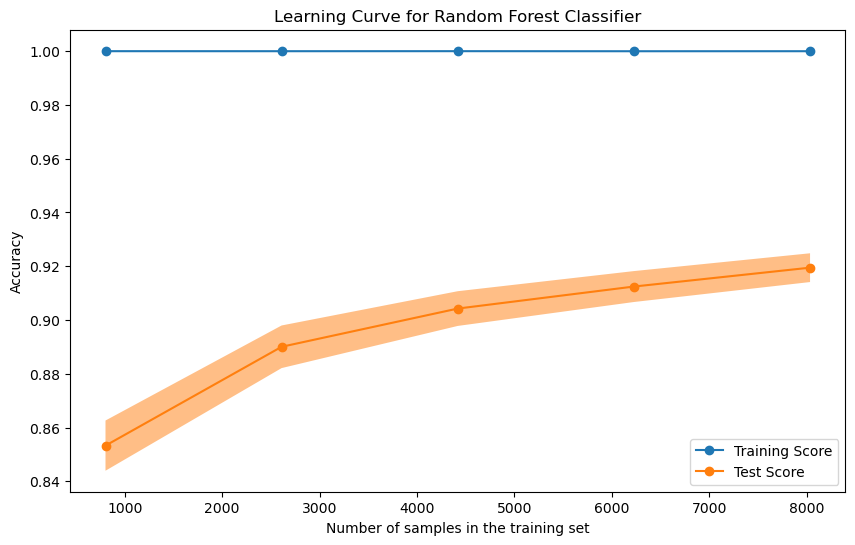

In [42]:
rf = RandomForestClassifier()
learning_curves(bin_x, bin_y, rf)
plt.title("Learning Curve for Random Forest Classifier")

### Grid Search & Evaluation Metrics

#### Logistic Regression

Accuracy: 79.3
              precision    recall  f1-score   support

         0.0       0.72      0.83      0.77       857
         1.0       0.86      0.76      0.81      1153

    accuracy                           0.79      2010
   macro avg       0.79      0.80      0.79      2010
weighted avg       0.80      0.79      0.79      2010



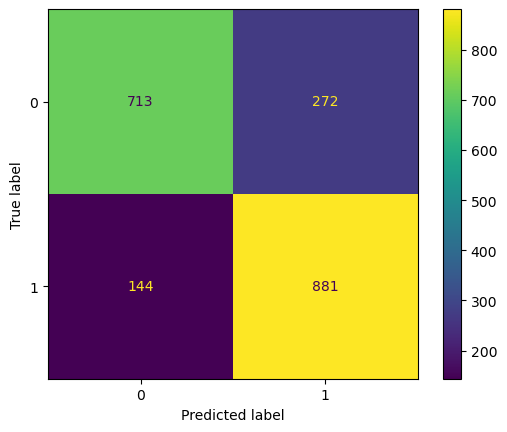

In [43]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, logr)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits
Best parameters: {'C': 0.001, 'l1_ratio': 0.0, 'penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77       985
         1.0       0.76      0.86      0.81      1025

    accuracy                           0.79      2010
   macro avg       0.80      0.79      0.79      2010
weighted avg       0.80      0.79      0.79      2010



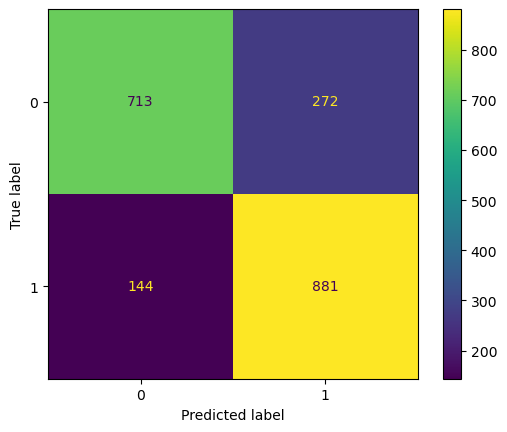

In [44]:
param_grid = {'penalty': ["l2", "elasticnet"], "C": np.linspace(0.001, 1, 100), "l1_ratio": np.linspace(0, 1, 20)} 
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, logr)

#### SVM - RBF Kernel

Accuracy: 80.1
              precision    recall  f1-score   support

         0.0       0.67      0.89      0.77       743
         1.0       0.92      0.75      0.83      1267

    accuracy                           0.80      2010
   macro avg       0.80      0.82      0.80      2010
weighted avg       0.83      0.80      0.80      2010



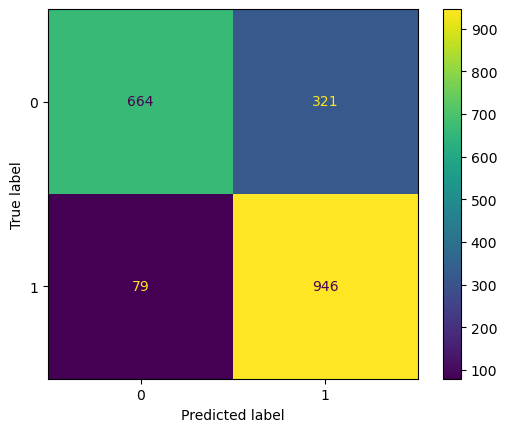

In [45]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, svm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77       985
         1.0       0.75      0.92      0.83      1025

    accuracy                           0.80      2010
   macro avg       0.82      0.80      0.80      2010
weighted avg       0.82      0.80      0.80      2010



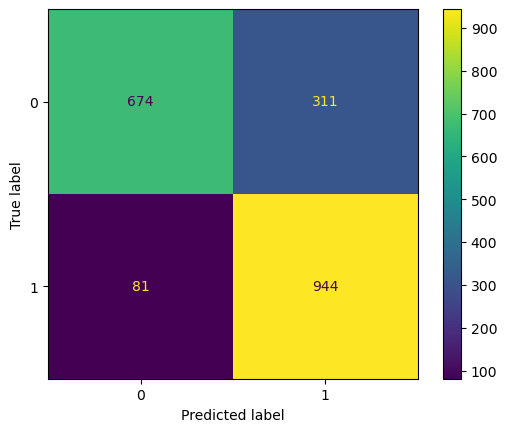

In [46]:
param_grid = {"kernel": ["rbf"], "C": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'gamma': ['scale', 'auto']}
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, svm)

#### Naive-Bayes

Accuracy: 78.06
              precision    recall  f1-score   support

         0.0       0.64      0.88      0.74       714
         1.0       0.92      0.73      0.81      1296

    accuracy                           0.78      2010
   macro avg       0.78      0.80      0.78      2010
weighted avg       0.82      0.78      0.79      2010



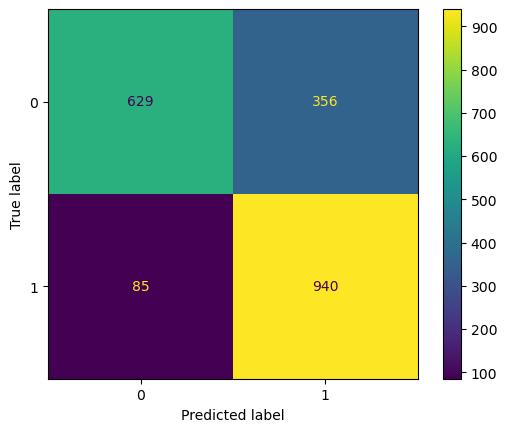

In [47]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, gnb)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'var_smoothing': 0.01}
              precision    recall  f1-score   support

         0.0       0.88      0.64      0.74       985
         1.0       0.73      0.92      0.81      1025

    accuracy                           0.78      2010
   macro avg       0.81      0.78      0.78      2010
weighted avg       0.80      0.78      0.78      2010



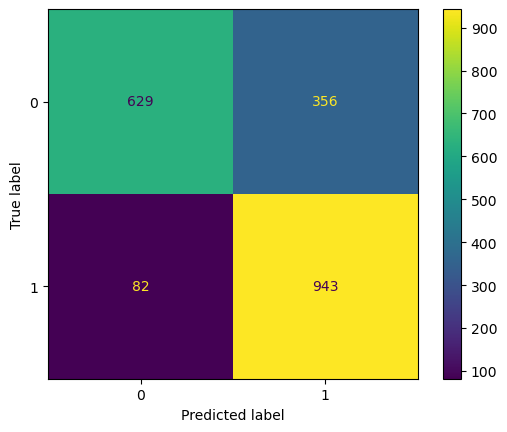

In [49]:
param_grid = {'var_smoothing': np.logspace(-12,-1,12)} 
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, gnb)

#### K-Nearest Neighbors

Accuracy: 89.5
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1004
         1.0       0.89      0.90      0.90      1006

    accuracy                           0.90      2010
   macro avg       0.90      0.90      0.90      2010
weighted avg       0.90      0.90      0.90      2010



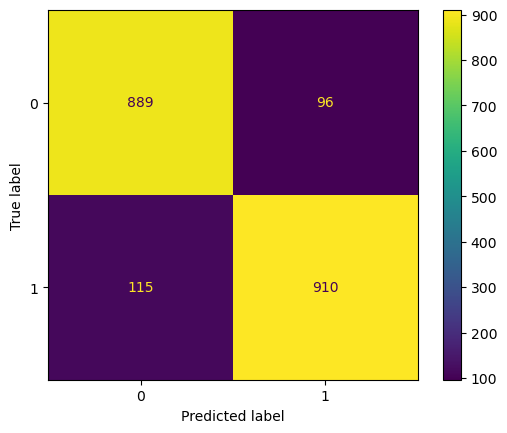

In [51]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, knn)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_neighbors': 6, 'p': 2, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91       985
         1.0       0.92      0.90      0.91      1025

    accuracy                           0.91      2010
   macro avg       0.91      0.91      0.91      2010
weighted avg       0.91      0.91      0.91      2010



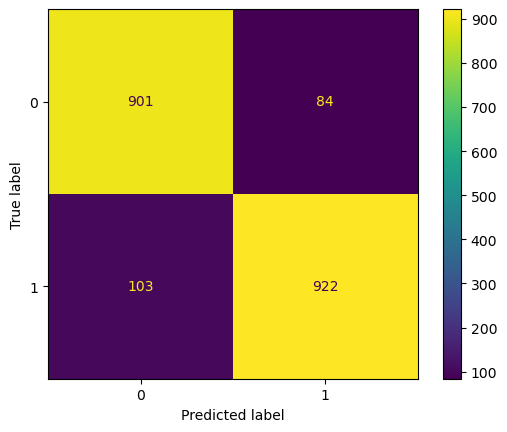

In [52]:
param_grid = {'n_neighbors': [3,4,5,6,7],
             'weights': ['uniform', 'distance'],
             'p': [1,2]} 
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, knn)

#### MLP Classifier

Accuracy: 79.1
              precision    recall  f1-score   support

         0.0       0.66      0.88      0.76       739
         1.0       0.92      0.74      0.82      1271

    accuracy                           0.79      2010
   macro avg       0.79      0.81      0.79      2010
weighted avg       0.82      0.79      0.79      2010



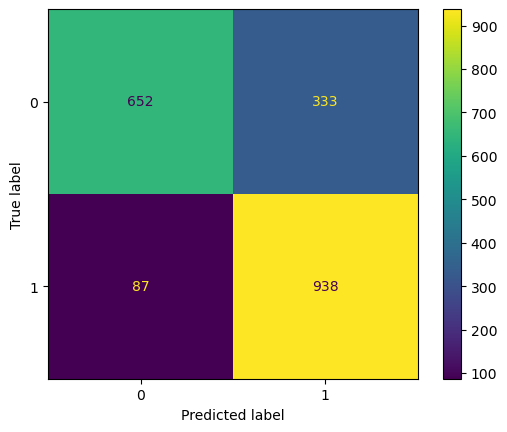

In [53]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, mlpc)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 100), 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.83      0.73      0.78       985
         1.0       0.77      0.86      0.81      1025

    accuracy                           0.80      2010
   macro avg       0.80      0.80      0.80      2010
weighted avg       0.80      0.80      0.80      2010



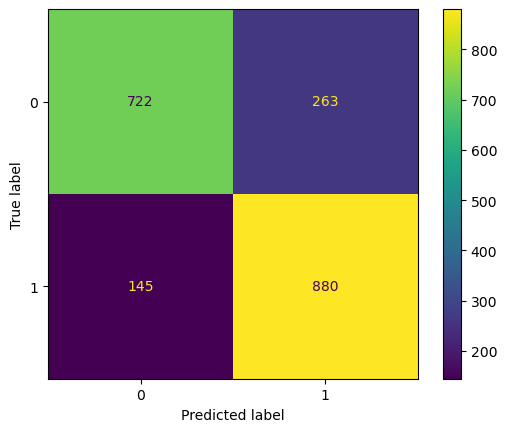

In [54]:
param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100)],
    'solver': ['lbfgs','sgd', 'adam'],
    'alpha': np.logspace(-5,-1,5)} 
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, mlpc)

#### Random Forests

Accuracy: 91.79
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92       974
         1.0       0.92      0.92      0.92      1036

    accuracy                           0.92      2010
   macro avg       0.92      0.92      0.92      2010
weighted avg       0.92      0.92      0.92      2010



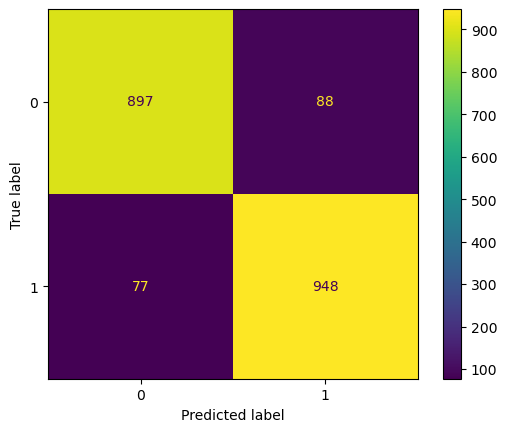

In [55]:
standard_fit(bin_x_train, bin_y_train, bin_x_test, bin_y_test, rf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       985
         1.0       0.92      0.92      0.92      1025

    accuracy                           0.92      2010
   macro avg       0.92      0.92      0.92      2010
weighted avg       0.92      0.92      0.92      2010



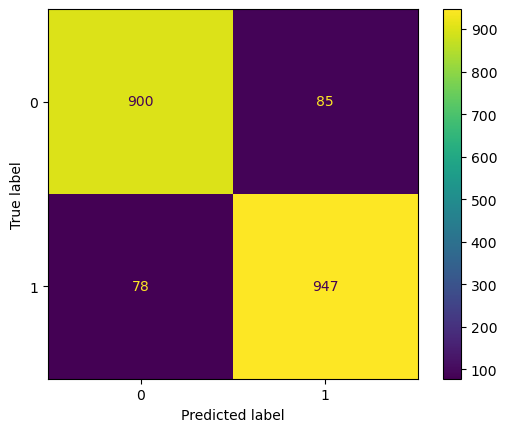

In [56]:
param_grid = {'bootstrap': [True, False],
 'max_features': ['auto', 'sqrt', 'log2'],            
 'n_estimators': [100, 250, 500, 750, 1000]} 
grid_search(param_grid, bin_x_train, bin_y_train, bin_x_test, bin_y_test, rf)

### Decision Boundary Graphs

In [57]:
classifiers = [GaussianNB(var_smoothing=0.01), KNeighborsClassifier(n_neighbors=6, p=2, weights='distance'), MLPClassifier(hidden_layer_sizes=(100,100),solver='lbfgs',alpha=0.001), 
               RandomForestClassifier(bootstrap = True, max_features = 'log2', n_estimators=1000), SVC(kernel='rbf', C=0.001, gamma='scale'), LogisticRegression(C=0.001, l1_ratio=0, penalty='l2')]
names = ['Naive-Bayes', 'K Nearest Neighbors', 'MLP Classifier', 'RandomForestClassifier', 'Kernel SVM', 'Logistic Regression']

In [64]:
for clf in classifiers:
    clf.fit(bin_x_train, bin_y_train)

In [65]:
#Limiting number of points for scatterplot
limit_x = bin_x[::20]
limit_y = bin_y[::20]

In [66]:
h = 10
x_min, x_max = bin_x[:, 0].min() - h, bin_x[:, 0].max() + h
y_min, y_max = bin_x[:, 1].min() - h, bin_x[:, 1].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [67]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

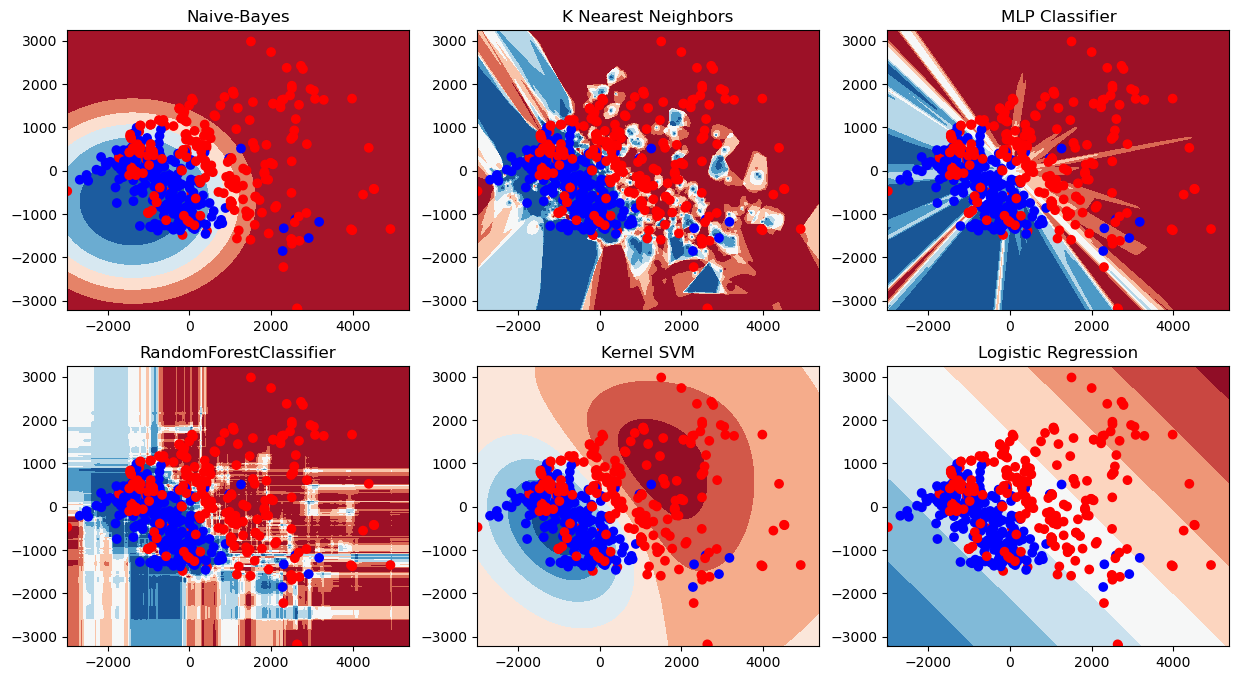

In [68]:
fig, ax = plt.subplots(2, 3, figsize=(15,8))
for n, (clf, name) in enumerate(zip(classifiers, names)):
    ax = plt.subplot(2, 3, n + 1)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm)
    plt.scatter(limit_x[:, 0], limit_x[:, 1], c=limit_y, cmap=cm_bright)
    ax.set_title("{}".format(name))
    #plt.savefig('boundarycomparison.png')

In [69]:
#fig, ax = plt.subplots(6, 1, figsize=(10,35))
#for n, (clf, name) in enumerate(zip(classifiers, names)):
#    ax = plt.subplot(6, 1, n + 1)
#    if hasattr(clf, "decision_function"):
#        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#    else:
#        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#    Z = Z.reshape(xx.shape)
#    plt.contourf(xx, yy, Z, cmap=cm)
#    plt.scatter(limit_x[:, 0], limit_x[:, 1], c=limit_y, cmap=cm_bright)
#    ax.set_title("{}".format(name))
#    plt.savefig('boundarycomparison-1.png')